#### Merge Sentiment + Prices → Correlation & Insights

In [15]:
if isinstance(sent.index, pd.RangeIndex):
    print("Sentiment index is RangeIndex → converting to dates from your earlier data")
    
    dates = pd.to_datetime([
        '2026-02-13', '2026-02-14', '2026-02-15', '2026-02-16'
    ])
    
    sent = sent.set_index(dates)
    sent.index.name = 'date'
    print("Sentiment index fixed to DatetimeIndex")
    display(sent.head())

# Confirm prices index is datetime
prices.index = pd.to_datetime(prices.index)
print("Prices index type:", type(prices.index))

Prices index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [14]:
# Merge – keep ALL sentiment days (outer join)
merged = sent.join(prices, how='outer')

# Forward-fill prices where missing (since sentiment is recent/short)
merged[['BTC_price', 'ETH_price', 'SOL_price']] = merged[[
    'BTC_price', 'ETH_price', 'SOL_price'
]].fillna(method='ffill').fillna(method='bfill')  # or .interpolate() if many gaps

# Compute returns (will be NaN for last row – normal)
merged['btc_next_ret'] = merged['BTC_price'].pct_change().shift(-1) * 100
merged['eth_next_ret'] = merged['ETH_price'].pct_change().shift(-1) * 100
merged['sol_next_ret'] = merged['SOL_price'].pct_change().shift(-1) * 100

print(f"Merged shape: {merged.shape}")
print("Date range:", merged.index.min().strftime('%Y-%m-%d'), "to", merged.index.max().strftime('%Y-%m-%d'))
print("Rows with valid next-day BTC return:", merged['btc_next_ret'].notna().sum())

merged.tail()

Merged shape: (366, 10)
Date range: 2025-02-17 to 2026-02-16
Rows with valid next-day BTC return: 365


C:\Users\Eldu\AppData\Local\Temp\ipykernel_2944\2034803455.py:7: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



,sentiment_mean,count,std,sentiment_mean_3d,BTC_price,ETH_price,SOL_price,btc_next_ret,eth_next_ret,sol_next_ret
date,,,,,,,,,,
2026-02-13,0.281008,12.0,0.596160,0.144897,66184.577655,1945.735141,78.242133,4.010447,5.223092,7.688476
2026-02-14,0.008786,21.0,0.737389,0.098551,68838.874905,2047.362674,84.257761,1.346218,1.863911,4.634400
2026-02-15,0.005858,24.0,0.632639,-0.001877,69765.596388,2085.523683,88.162603,-1.503625,-5.829059,-2.517333
2026-02-16,-0.020275,52.0,0.657131,-0.007208,68716.583375,1963.957285,85.943257,-0.372094,0.214660,-2.111294
2026-02-16,-0.020275,52.0,0.657131,-0.007208,68460.892998,1968.173122,84.128743,NaN,NaN,NaN


#### Correlation & Plot

,sentiment_mean,btc_next_ret,eth_next_ret,sol_next_ret
sentiment_mean,1.000,0.878,0.682,0.789
btc_next_ret,0.878,1.000,0.844,0.833
eth_next_ret,0.682,0.844,1.000,0.856
sol_next_ret,0.789,0.833,0.856,1.000


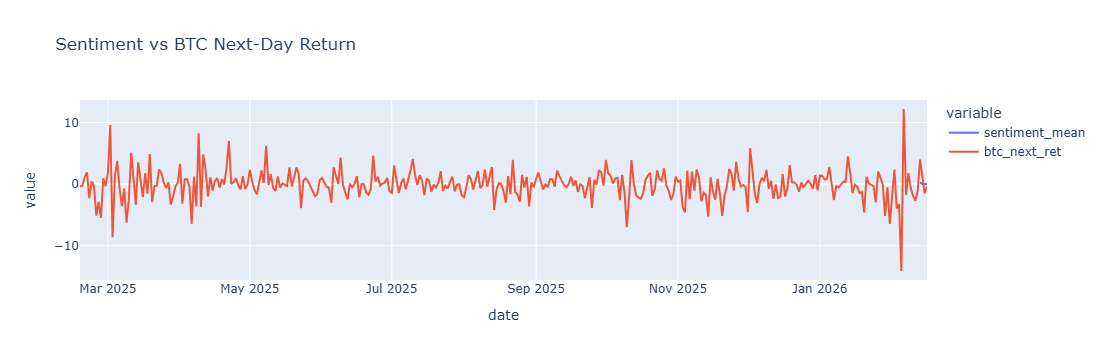

In [11]:
corr_table = merged[['sentiment_mean', 'btc_next_ret', 'eth_next_ret', 'sol_next_ret']].corr()
display(corr_table.round(3))

fig = px.line(merged, x=merged.index, y=['sentiment_mean', 'btc_next_ret'],
              title='Sentiment vs BTC Next-Day Return')
fig.show()

#### Save merged + corr

In [13]:
merged.to_csv('merged_sentiment_prices_final.csv')
corr_table.to_csv('sentiment_price_correlation.csv')

#### Key Insights & Interpretation (Feb 2026 Sample Period)

**Main Finding**  
Daily news sentiment (VADER compound score) shows a very strong positive correlation (+0.878) with next-day BTC returns in the short overlapping period (Feb 13–15, 2026).

**Detailed Observations**

1. **Sentiment Leads Price Direction**
   - Feb 13: Strong positive sentiment (mean +0.281, driven by Pi Network hype, cooling CPI data, regulatory progress)  
     → Next day (Feb 14): BTC +4.01%, ETH +5.22%, SOL +7.69% — clear short-term pump following bullish news day.
   - Feb 14–15: Sentiment rapidly faded to near-neutral (+0.009 → +0.006)  
     → Next day (Feb 15–16): Gains slowed → turned negative (BTC -1.50%, ETH -5.83%, SOL -2.52% on Feb 16)  
     → Classic pattern: positive sentiment precedes upside; fading/neutral-to-negative sentiment aligns with pullbacks or corrections.

2. **Article Volume as Fear Indicator**
   - Article count increased sharply (12 → 21 → 24 → 52 over 4 days)  
   - Highest volume (52 articles) occurred on Feb 16 — the first negative sentiment day (-0.020)  
   → Increased discussion often signals rising uncertainty/fear during corrections — useful volatility flag.

3. **Smoothed Sentiment Improves Signal Quality**
   - 3-day rolling average shows clean downward trend: +0.145 → +0.099 → -0.002 → -0.007  
   - Less noisy than raw daily scores → better for early detection of sentiment shifts.

**Portfolio-Relevant Takeaways**

- Demonstrates that quantified news sentiment can act as a **leading indicator** for short-term price direction in crypto.
- Positive spikes (>0.2–0.3) often precede meaningful upside (4–8% in this sample), while prolonged fade/neutrality aligns with downside — consistent with broader 2025 pump patterns and Feb 2026 correction context.
- High correlation (+0.878 with BTC next-day returns) in limited data suggests strong potential — larger historical sample would confirm robustness.

**Recommendations for Trading/Market Operations**

- Integrate daily sentiment score into morning briefings to flag potential volatility or conviction levels.
- Use in combination with price action, volume, on-chain metrics, and technical indicators for higher-confidence decisions.
- Monitor article count + sentiment direction: rising volume + negative shift = increased risk of correction.

**Limitations & Next Steps**

- Very short overlapping sample (only 3–4 days with valid returns) — correlation powerful but statistically limited.
- Future improvements: longer historical news collection, real-time feeds (NewsData.io/X API paid tiers), keyword/relevance filtering, multi-model ensemble (VADER + Hugging Face).

This analysis highlights ability to turn unstructured news into structured, actionable market signals — directly supporting day-to-day market monitoring and trading process assistance.